In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
landMarks = pd.read_csv('../../processing/landmarking/mit/mitLandmarks.csv',index_col = 0)
imageList = list(set(landMarks.index.tolist()))
imageList.sort()
X_LMmatrix = np.zeros((len(imageList),68))
Y_LMmatrix = np.zeros((len(imageList),68))

# x = landMarks.ix[images[0]].x.tolist()
# print x
imList = imageList

for im in imageList:
    ind_im = imageList.index(im)
    imList[ind_im] = im[3:]
    X_LMmatrix[ind_im,:] = landMarks.ix[im].x.tolist()
    Y_LMmatrix[ind_im,:] = landMarks.ix[im].y.tolist()

In [2]:
from PIL import Image
import colorsys
import random
# print Rectangle((someX, someY), yLength, yLength*0.5)
def get3RegionRect(X_LMmatrix,Y_LMmatrix, imInd):
    yLengthArr = []
    xLengthArr = []
    someX_Arr = []
    someY_Arr = []
    #left patch
    yLengthArr.append(Y_LMmatrix[imInd,4]-Y_LMmatrix[imInd,3])
    xLengthArr.append((X_LMmatrix[imInd,48]-X_LMmatrix[imInd,2])/2)
    someX_Arr.append((X_LMmatrix[imInd,48]+X_LMmatrix[imInd,3])/2-xLengthArr[0]/2) 
    someY_Arr.append((Y_LMmatrix[imInd,2]+Y_LMmatrix[imInd,29])/2-yLengthArr[0]/2)
    #right patch
    yLengthArr.append(Y_LMmatrix[imInd,12]-Y_LMmatrix[imInd,13])
    xLengthArr.append((X_LMmatrix[imInd,12]-X_LMmatrix[imInd,54])/2)
    someX_Arr.append((X_LMmatrix[imInd,54]+X_LMmatrix[imInd,13])/2-xLengthArr[1]/2) 
    someY_Arr.append((Y_LMmatrix[imInd,29]+Y_LMmatrix[imInd,14])/2-yLengthArr[1]/2)
    #top patch
    yLengthArr.append((X_LMmatrix[imInd,22]-X_LMmatrix[imInd,21])/2)
    xLengthArr.append(X_LMmatrix[imInd,22]-X_LMmatrix[imInd,21])
    someX_Arr.append((X_LMmatrix[imInd,21]+X_LMmatrix[imInd,22])/2-xLengthArr[2]/2) 
    someY_Arr.append((Y_LMmatrix[imInd,21]+Y_LMmatrix[imInd,22])/2-yLengthArr[2]/2)
    return someX_Arr, someY_Arr, xLengthArr, yLengthArr

def findAllCoors(someX, someY, xLength, yLength):
    Xmatrix = np.zeros((int(xLength),int(yLength)))
    Ymatrix = np.zeros((int(xLength),int(yLength)))
    for i in range(int(xLength)):
        for j in range(int(yLength)):
            Xmatrix[i,j] = int(someX)+i
            Ymatrix[i,j] = int(someY)+j
    return Xmatrix,Ymatrix

def getAveColor (someX, someY, xLength, yLength, imageName):
    im = Image.open(imageName)
    rgb_im = im.convert('RGB')
    Xmatrix,Ymatrix = findAllCoors(someX, someY, xLength, yLength) 
    Xsize, Ysize = Xmatrix.shape
    hValue = np.zeros((Xsize, Ysize))
    sValue = np.zeros((Xsize, Ysize))
    vValue = np.zeros((Xsize, Ysize))
    for i in range(Xsize):
        for j in range (Ysize):
            r, g, b = rgb_im.getpixel((Xmatrix[i,j],Ymatrix[i,j]))
            hValue[i,j],sValue[i,j],vValue[i,j] = colorsys.rgb_to_hsv(r/255.0, g/255.0, b/255.0)
    return [hValue.mean(),sValue.mean(),vValue.mean()]

rand_int = imList.index(random.choice(imList))
meanHSV = np.zeros((len(imList), 3))
for imInd in range(len(imList)):
    someX_Arr, someY_Arr, xLengthArr, yLengthArr = get3RegionRect(X_LMmatrix,Y_LMmatrix, imInd)
    tempMean = np.zeros((1,3))
    for j in range(len(someX_Arr)):
        tempMean += np.asarray(getAveColor(someX_Arr[j], someY_Arr[j], xLengthArr[j], yLengthArr[j], imList[imInd]))
    meanHSV[imInd,:] = tempMean/3

In [3]:
print 'H mean: ', meanHSV[:,0].mean(),', S mean: ', meanHSV[:,1].mean(), ', V mean: ', meanHSV[:,2].mean()
print 'H std: ', meanHSV[:,0].std(),', S std: ', meanHSV[:,1].std(),', V std: ', meanHSV[:,2].std()

H mean:  0.101154218545 , S mean:  0.392194580956 , V mean:  0.767811662084
H std:  0.162586053503 , S std:  0.114747951156 , V std:  0.115534603901


In [4]:
from skimage import feature, color, io
# Compute the Canny filter for two values of sigma
def getSmoothness(imageName, someX_Arr, someY_Arr, xLengthArr, yLengthArr, ifPlot = False,sigma=1):
    BigImage = color.rgb2gray(io.imread(imageName))
    edged = feature.canny(BigImage, sigma = sigma)
    #print BigImage.shape
    if ifPlot:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), sharex=True, sharey=True)

        ax1.imshow(BigImage, cmap=plt.cm.gray)
        ax1.axis('off')
        ax1.set_title('original image', fontsize=20)

        ax2.imshow(edged, cmap=plt.cm.gray)
        ax2.axis('off')
        ax2.set_title('Canny filter, $\sigma='+str(sigma)+'$', fontsize=20)

        fig.subplots_adjust(wspace=0.02, hspace=0.02, top=0.9,
                            bottom=0.02, left=0.02, right=0.98)
        plt.show()
    aveEdgeNum = 0.0
    for j in range(len(someX_Arr)):
        image = BigImage[int(someY_Arr[j]):int(someY_Arr[j]+yLengthArr[j])\
                  ,int(someX_Arr[j]):int(someX_Arr[j]+xLengthArr[j])]
        edged = feature.canny(image, sigma = sigma)
        if ifPlot:
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), sharex=True, sharey=True)

            ax1.imshow(image, cmap=plt.cm.gray)
            ax1.axis('off')
            ax1.set_title('original image', fontsize=20)

            ax2.imshow(edged, cmap=plt.cm.gray)
            ax2.axis('off')
            ax2.set_title('Canny filter, $\sigma='+str(sigma)+'$', fontsize=20)

            fig.subplots_adjust(wspace=0.02, hspace=0.02, top=0.9,
                                bottom=0.02, left=0.02, right=0.98)
            plt.show()
        aveEdgeNum += edged.sum()
        #print image.shape
    aveEdgeNum /=float(len(someX_Arr))
    return aveEdgeNum
smoothness = np.zeros((len(imList),1))
custom_sigma = 0.33
ifPlot = False
for imInd in range(len(imList)):
    someX_Arr, someY_Arr, xLengthArr, yLengthArr = get3RegionRect(X_LMmatrix,Y_LMmatrix, imInd)
    #print someX_Arr, someY_Arr, xLengthArr, yLengthArr
    smoothness[imInd] = \
    getSmoothness(imList[imInd], someX_Arr, someY_Arr, xLengthArr, yLengthArr,sigma=custom_sigma,ifPlot = ifPlot)

print 'smoothness mean: ',smoothness.mean(),', smoothness std: ', smoothness.std()

smoothness mean:  36.3988823441 , smoothness std:  26.1724793184


In [5]:
# save as a csv
from pandas import DataFrame
data = np.concatenate((meanHSV,smoothness), axis=1)
geometric = pd.read_csv('../../MIT2kFaceDataset/clean_data/geometric_all.csv',index_col = 0)
df = DataFrame(data,columns=['h', 's', 'v', 'smoothness'])
config_feature = geometric.loc[:,'nose_width':'AV']
config_feature = pd.concat([config_feature,df], axis=1)
not_measure_feature = config_feature.loc[:,'FA':'smoothness']
print not_measure_feature.columns
config_feauture = config_feature.as_matrix()
not_measure_feature = not_measure_feature.as_matrix()
df = pd.concat([geometric,df], axis=1)
df.to_csv('../../MIT2kFaceDataset/clean_data/geometric_wSmoothness.csv',index = False)
df = pd.read_csv('../../MIT2kFaceDataset/clean_data/geometric_wSmoothness.csv',index_col = 0)


Index([u'FA', u'CA', u'AV', u'h', u's', u'v', u'smoothness'], dtype='object')


In [6]:
def computeDist(X_LMmatrix,Y_LMmatrix, imInd):
    pointNum = X_LMmatrix.shape[1]
    distArr = np.zeros((1,pointNum*(pointNum-1)/2))
    distInd = 0
    for i in range(pointNum):
        for j in range(i+1,pointNum):
            x1 = np.asarray([X_LMmatrix[imInd,i],Y_LMmatrix[imInd,i]])
            x2 = np.asarray([X_LMmatrix[imInd,j],Y_LMmatrix[imInd,j]])
            distArr[0,distInd] = np.linalg.norm(x1-x2)
            distInd +=1
    return distArr
import sys
def computeSlope(X_LMmatrix,Y_LMmatrix, imInd):
    pointNum = X_LMmatrix.shape[1]
    slopeArr = np.zeros((1,pointNum*(pointNum-1)/2))
    slopeInd = 0
    for i in range(pointNum):
        for j in range(i+1,pointNum):
            denominator = float(X_LMmatrix[imInd,i]-X_LMmatrix[imInd,j])
            if denominator != 0:
                slopeArr[0,slopeInd] = float(Y_LMmatrix[imInd,i]-Y_LMmatrix[imInd,j])/denominator
            else:
                #print i,j
                if float(Y_LMmatrix[imInd,i]-Y_LMmatrix[imInd,j]) > 0:
                    slopeArr[0,slopeInd] = sys.float_info.max/100000
                elif float(Y_LMmatrix[imInd,i]-Y_LMmatrix[imInd,j]) ==0:
                    slopeArr[0,slopeInd] = 0
                else:
                    slopeArr[0,slopeInd] = -sys.float_info.max/100000
            slopeInd +=1
    return slopeArr
def computeCosine(X_LMmatrix,Y_LMmatrix, imInd):
    pointNum = X_LMmatrix.shape[1]
    cosineArr = np.zeros((1,pointNum*(pointNum-1)/2))
    cosineInd = 0
    for i in range(pointNum):
        for j in range(i+1,pointNum):
            denominator = float(X_LMmatrix[imInd,i]-X_LMmatrix[imInd,j])
            if denominator != 0:
                cosineArr[0,cosineInd] = np.cos(np.arctan(float(Y_LMmatrix[imInd,i]-Y_LMmatrix[imInd,j])/denominator))
            else:
                cosineArr[0,cosineInd] = 0
            cosineInd +=1
    return cosineArr


distMat = np.zeros((len(imList),X_LMmatrix.shape[1]*(X_LMmatrix.shape[1]-1)/2))
slopeMat = np.zeros((len(imList),X_LMmatrix.shape[1]*(X_LMmatrix.shape[1]-1)/2))
for imInd in range(len(imList)):
    distArr = computeDist(X_LMmatrix,Y_LMmatrix, imInd)
    slopeArr = computeCosine(X_LMmatrix,Y_LMmatrix, imInd)
    distMat[imInd,:] = distArr
    slopeMat[imInd,:] = slopeArr


In [7]:
distSlope = np.concatenate((slopeMat,distMat), axis=1)
allGeometric = np.concatenate((config_feature,distSlope),axis = 1)
only_w_pixel = np.concatenate((meanHSV,smoothness,distSlope),axis = 1)

from sklearn.decomposition import PCA as sklearnPCA
explained_variance = distSlope.shape[0]
sklearn_pca = sklearnPCA(n_components=explained_variance, whiten = True)
distSlope_transf = sklearn_pca.fit_transform(distSlope)
print 'The number of PCs needed to retain %.3f variance is %d.' \
      % (explained_variance, distSlope_transf.shape[1])

sklearn_pca = sklearnPCA(n_components=explained_variance, whiten = True)
allGeometric_transf = sklearn_pca.fit_transform(allGeometric)
print 'The number of PCs needed to retain %.3f variance is %d.' \
      % (explained_variance, allGeometric_transf.shape[1])
    
sklearn_pca = sklearnPCA(n_components=explained_variance, whiten = True)
only_w_pixel_transf = sklearn_pca.fit_transform(only_w_pixel)
print 'The number of PCs needed to retain %.3f variance is %d.' \
      % (explained_variance, only_w_pixel_transf.shape[1])

config_distPCA = np.concatenate((config_feature,distSlope_transf),axis = 1)
dist_slope_nonConfig = np.concatenate((not_measure_feature,distSlope_transf),axis = 1)

The number of PCs needed to retain 2207.000 variance is 2207.
The number of PCs needed to retain 2207.000 variance is 2207.
The number of PCs needed to retain 2207.000 variance is 2207.


In [8]:
mean_rating = geometric.attractive.as_matrix()
print len(mean_rating)
mean_rating = map(float, mean_rating)
mean_rating = np.array(mean_rating)
import sys
#print sys.path
# local
PkgPath = '/Users/Olivialinlin/Documents/Github/attractiveness_datamining/linjieCode/code'
# server
# PkgPath = '/home/lli-ms/attractiveness_datamining/linjieCode/code'

if PkgPath not in sys.path:
    sys.path.insert(0, PkgPath)
#print sys.path
from xVal_train_test import Train_Test

baseLine = mean_rating.mean()
print 'mean rating: ', baseLine
import sklearn
numFeatureArr = np.linspace(1,1000,num =50 ,dtype = np.int16)
valCorr = []
trainCorr = []
for numFeature in numFeatureArr:
    predictionModel = sklearn.linear_model.RidgeCV(alphas=np.logspace(-3,2,num=20), fit_intercept=True)
    valC, trainC = Train_Test(mean_rating,distSlope_transf, hyperParam = numFeature, xVal = False,\
                              pModel = predictionModel,numTrain = 50,savePath = '../Result/mit',MODEL= 'distSlope')
    
    valCorr.append(valC)
    trainCorr.append(trainC)

print numFeatureArr[valCorr.index(max(valCorr))]
print max(valCorr)

2207
mean rating:  4.93915489035
62
0.535707226033


In [9]:
numFeatureArr = np.linspace(1,1000,num =50 ,dtype = np.int16)
valCorr = []
trainCorr = []
for numFeature in numFeatureArr:
    predictionModel = sklearn.linear_model.RidgeCV(alphas=np.logspace(-3,2,num=20), fit_intercept=True)
    valC, trainC = Train_Test(mean_rating,only_w_pixel_transf, hyperParam = numFeature, xVal = False,\
                              pModel = predictionModel,numTrain = 50,savePath = '../Result/mit',MODEL= 'distSlope')
    
    valCorr.append(valC)
    trainCorr.append(trainC)

print numFeatureArr[valCorr.index(max(valCorr))]
print max(valCorr)

62
0.541384165364


In [10]:
numFeatureArr = np.linspace(1,1000,num =50 ,dtype = np.int16)
valCorr = []
trainCorr = []
for numFeature in numFeatureArr:
    predictionModel = sklearn.linear_model.RidgeCV(alphas=np.logspace(-3,2,num=20), fit_intercept=True)
    valC, trainC = Train_Test(mean_rating,allGeometric_transf, hyperParam = numFeature, xVal = False,\
                              pModel = predictionModel,numTrain = 50,savePath = '../Result/mit',MODEL= 'distSlope')
    
    valCorr.append(valC)
    trainCorr.append(trainC)

print numFeatureArr[valCorr.index(max(valCorr))]
print max(valCorr)

41
0.544528682057


In [13]:
numFeatureArr = np.linspace(40,1000,num =50 ,dtype = np.int16)
valCorr = []
trainCorr = []
for numFeature in numFeatureArr:
    predictionModel = sklearn.linear_model.RidgeCV(alphas=np.logspace(-3,2,num=20), fit_intercept=True)
    valC, trainC = Train_Test(mean_rating,config_distPCA, hyperParam = numFeature, xVal = False,\
                              pModel = predictionModel,numTrain = 50,savePath = '../Result/mit',MODEL= 'distSlope')
    
    valCorr.append(valC)
    trainCorr.append(trainC)

print numFeatureArr[valCorr.index(max(valCorr))]
print max(valCorr)

98
0.549999425054


In [19]:
numFeatureArr = np.linspace(5,1000,num =50 ,dtype = np.int16)
valCorr = []
trainCorr = []
for numFeature in numFeatureArr:
    predictionModel = sklearn.linear_model.RidgeCV(alphas=np.logspace(-3,2,num=20), fit_intercept=True)
    valC, trainC = Train_Test(mean_rating,dist_slope_nonConfig, hyperParam = numFeature, xVal = False,\
                              pModel = predictionModel,numTrain = 50,savePath = '../Result/mit',\
                              returnValTrain = True, MODEL= 'distSlope')
    
    valCorr.append(valC)
    trainCorr.append(trainC)

print numFeatureArr[valCorr.index(max(valCorr))]
print max(valCorr)

86
0.552022666189


2207
mean rating:  4.93915489035
**************************Result of train and test**************************************
number of features: 86
On validation set:
Residual sum of squares: 1.01
Variance score is: 0.31
Correlation between predicted ratings and actual ratings is: 0.5606
 
On training set:
Residual sum of squares: 0.85
Variance score is: 0.40
Correlation between predicted ratings and actual ratings is: 0.6340
****************************************************************************************
**************************Result of predicted max and min on testing set****************
maxIndex:  [ 624 1980  889 1095  123]
minIndex:  [ 708 1250  689  741 2143]
maxRating:  [ 6.57699069  6.66179222  6.77462633  6.79273405  6.84094346]
minRating:  [ 2.63839187  2.99483437  2.99498909  3.01950349  3.03119313]
****************************************************************************************


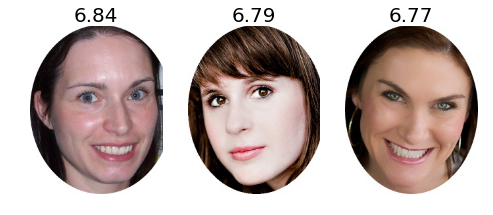

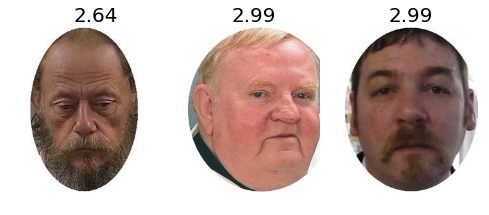

In [11]:
mean_rating = geometric.attractive.as_matrix()
print len(mean_rating)
mean_rating = map(float, mean_rating)
mean_rating = np.array(mean_rating)
import sys
#print sys.path
# local
PkgPath = '/Users/Olivialinlin/Documents/Github/attractiveness_datamining/linjieCode/code'
# server
# PkgPath = '/home/lli-ms/attractiveness_datamining/linjieCode/code'

if PkgPath not in sys.path:
    sys.path.insert(0, PkgPath)
#print sys.path
from xVal_train_test import Train_Test
import sklearn
baseLine = mean_rating.mean()
print 'mean rating: ', baseLine
feature_designed = dist_slope_nonConfig[:,:86]
predictionModel = sklearn.linear_model.RidgeCV(alphas=np.logspace(-3,2,num=20), fit_intercept=True)
maxRating,maxIndex,minRating,minIndex = \
Train_Test(mean_rating,feature_designed, hyperParam = 86, xVal = False,\
            pModel = predictionModel,numTrain = 1,savePath = '../Result/mit',\
                          getMaxMin = True, MODEL= 'distSlope')
imListNP = np.asarray(imList)
minImage = imListNP[minIndex]
maxImage = imListNP[maxIndex]
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True)

ax1.imshow(plt.imread(maxImage[-1]))
ax1.axis('off')
ax1.set_title(str("{0:.2f}".format(maxRating[-1])), fontsize=20)

ax2.imshow(plt.imread(maxImage[-2]))
ax2.axis('off')
ax2.set_title(str("{0:.2f}".format(maxRating[-2])), fontsize=20)

ax3.imshow(plt.imread(maxImage[-3]))
ax3.axis('off')
ax3.set_title(str("{0:.2f}".format(maxRating[-3])), fontsize=20)


# ax4.imshow(edges3, cmap=plt.cm.gray)
# ax4.axis('off')
# ax4.set_title('auto', fontsize=20)



fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True)

ax1.imshow(plt.imread(minImage[0]))
ax1.axis('off')
ax1.set_title(str("{0:.2f}".format(minRating[0])), fontsize=20)

ax2.imshow(plt.imread(minImage[1]))
ax2.axis('off')
ax2.set_title(str("{0:.2f}".format(minRating[1])), fontsize=20)

ax3.imshow(plt.imread(minImage[2]))
ax3.axis('off')
ax3.set_title(str("{0:.2f}".format(minRating[2])), fontsize=20)


# ax4.imshow(edges3, cmap=plt.cm.gray)
# ax4.axis('off')
# ax4.set_title('auto', fontsize=20)



**************************Result of predicted max and min on testing set****************
maxIndex:  [1518 1700  341  787 1607]
minIndex:  [1236  581  912 1262  708]
maxRating:  [ 8.        8.066667  8.133333  8.2       8.2     ]
minRating:  [ 1.733333  1.933333  2.        2.066667  2.125   ]
****************************************************************************************


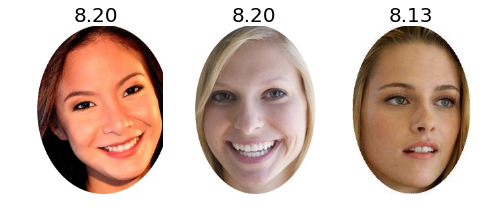

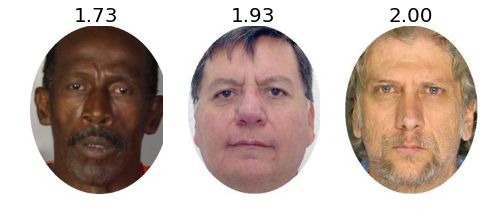

In [12]:
from xVal_train_test import getPredResult
maxRating,maxIndex,minRating,minIndex = getPredResult(mean_rating,range(len(imList)))
minImage = imListNP[minIndex]
maxImage = imListNP[maxIndex]
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True)

ax1.imshow(plt.imread(maxImage[-1]))
ax1.axis('off')
ax1.set_title(str("{0:.2f}".format(maxRating[-1])), fontsize=20)

ax2.imshow(plt.imread(maxImage[-2]))
ax2.axis('off')
ax2.set_title(str("{0:.2f}".format(maxRating[-2])), fontsize=20)

ax3.imshow(plt.imread(maxImage[-3]))
ax3.axis('off')
ax3.set_title(str("{0:.2f}".format(maxRating[-3])), fontsize=20)


# ax4.imshow(edges3, cmap=plt.cm.gray)
# ax4.axis('off')
# ax4.set_title('auto', fontsize=20)



fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True)

ax1.imshow(plt.imread(minImage[0]))
ax1.axis('off')
ax1.set_title(str("{0:.2f}".format(minRating[0])), fontsize=20)

ax2.imshow(plt.imread(minImage[1]))
ax2.axis('off')
ax2.set_title(str("{0:.2f}".format(minRating[1])), fontsize=20)

ax3.imshow(plt.imread(minImage[2]))
ax3.axis('off')
ax3.set_title(str("{0:.2f}".format(minRating[2])), fontsize=20)


# ax4.imshow(edges3, cmap=plt.cm.gray)
# ax4.axis('off')
# ax4.set_title('auto', fontsize=20)



In [ ]:
from matplotlib.patches import Rectangle
import random
#imInd = imList.index(random.choice(imList))
im = plt.imread(imList[imInd])
fSize = 6
implot = plt.imshow(im)
import pylab
# put a blue dot at (10, 20)
plt.scatter(X_LMmatrix[imInd,:],Y_LMmatrix[imInd,:])
labels = [str(i) for i in range(68)]
for label, x, y in zip(labels, X_LMmatrix[imInd,:], Y_LMmatrix[imInd,:]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
yLengthArr = []
xLengthArr = []
someX_Arr = []
someY_Arr = []
# left patch
yLengthArr.append(Y_LMmatrix[imInd,4]-Y_LMmatrix[imInd,3])
xLengthArr.append((X_LMmatrix[imInd,48]-X_LMmatrix[imInd,2])/2)
someX_Arr.append((X_LMmatrix[imInd,48]+X_LMmatrix[imInd,3])/2-xLength[0]/2) 
someY_Arr.append((Y_LMmatrix[imInd,2]+Y_LMmatrix[imInd,29])/2-yLength[0]/2)
# right patch
yLengthArr.append(Y_LMmatrix[imInd,12]-Y_LMmatrix[imInd,13])
xLengthArr.append((X_LMmatrix[imInd,12]-X_LMmatrix[imInd,54])/2)
someX_Arr.append((X_LMmatrix[imInd,54]+X_LMmatrix[imInd,13])/2-xLength[1]/2) 
someY_Arr.append((Y_LMmatrix[imInd,29]+Y_LMmatrix[imInd,14])/2-yLength[1]/2)
# top patch
yLengthArr.append((X_LMmatrix[imInd,22]-X_LMmatrix[imInd,21])/2)
xLengthArr.append(X_LMmatrix[imInd,22]-X_LMmatrix[imInd,21])
someX_Arr.append((X_LMmatrix[imInd,21]+X_LMmatrix[imInd,22])/2-xLength[2]/2) 
someY_Arr.append((Y_LMmatrix[imInd,21]+Y_LMmatrix[imInd,22])/2-yLength[2]/2)
currentAxis = plt.gca()
for i in range(len(xLength)):
    currentAxis.add_patch(Rectangle((someX_Arr[i], someY_Arr[i]), xLengthArr[i], yLengthArr[i], facecolor="grey"))
    
fig = pylab.gcf()
fig.set_size_inches(5*fSize, 3*fSize)
plt.show()
print someX_Arr, someY_Arr, xLengthArr, yLengthArr
print X_LMmatrix[imInd,2], Y_LMmatrix[imInd,2]

In [ ]:
from PIL import Image
im_Image = Image.open(imList[imInd])
rgb_im = im_Image.convert('RGB')
r, g, b = rgb_im.getpixel((X_LMmatrix[imInd,1],Y_LMmatrix[imInd,1]))
print r,g,b
import colorsys
h,s,v = colorsys.rgb_to_hsv(r/255.0, g/255.0, b/255.0)
print h,s,v

print im[int(Y_LMmatrix[imInd,1]),int(X_LMmatrix[imInd,1]),:]

In [ ]:

img = color.rgb2gray(io.imread(imList[imInd]))
smallRegion = img[int(someX_Arr[1]):int(someX_Arr[1]+xLengthArr[1])\
                  ,int(someY_Arr[1]):int(someY_Arr[1]+yLengthArr[1])]
#im = smallRegion
im = img
custom_sigma = 0.33
#edges3 = auto_canny(im, sigma = 0.9)
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma = custom_sigma)
print edges1.sum()
print edges2.sum()
#print edges3.sum()
# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('original image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma='+str(custom_sigma)+'$', fontsize=20)

# ax4.imshow(edges3, cmap=plt.cm.gray)
# ax4.axis('off')
# ax4.set_title('auto', fontsize=20)

fig.subplots_adjust(wspace=0.02, hspace=0.02, top=0.9,
                    bottom=0.02, left=0.02, right=0.98)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import roberts, sobel, scharr, prewitt
from skimage import color
from skimage import io

img = color.rgb2gray(io.imread(imList[imInd]));

edge_sobel = sobel(img)
edge_scharr = scharr(img)
edge_prewitt = prewitt(img)

diff_scharr_prewitt = edge_scharr - edge_prewitt
diff_scharr_sobel = edge_scharr - edge_sobel
max_diff = np.max(np.maximum(diff_scharr_prewitt, diff_scharr_sobel))

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})

ax0.imshow(img, cmap=plt.cm.gray)
ax0.set_title('Original image')
ax0.axis('off')

ax1.imshow(edge_scharr, cmap=plt.cm.gray)
ax1.set_title('Scharr Edge Detection')
ax1.axis('off')

ax2.imshow(diff_scharr_prewitt, cmap=plt.cm.jet, vmax=max_diff)
ax2.set_title('Scharr - Prewitt')
ax2.axis('off')

ax3.imshow(diff_scharr_sobel, cmap=plt.cm.jet, vmax=max_diff)
ax3.set_title('Scharr - Sobel')
ax3.axis('off')

plt.tight_layout()
plt.show()

